# Copy from [APTOS [UpdatedV14] Preprocessing- Ben's & Cropping](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping)

In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [6]:
df_train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df_test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

x = df_train['id_code']
y = df_train['diagnosis']
            
x, y = shuffle(x, y, random_state=SEED)

(3112,) (550,) (3112,) (550,)


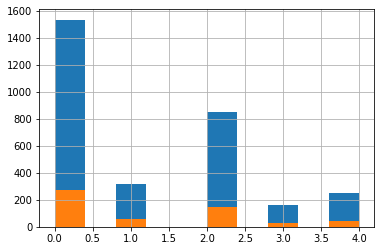

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15, stratify=y, random_state=SEED)
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

CPU times: user 3.12 s, sys: 252 ms, total: 3.37 s
Wall time: 3.13 s


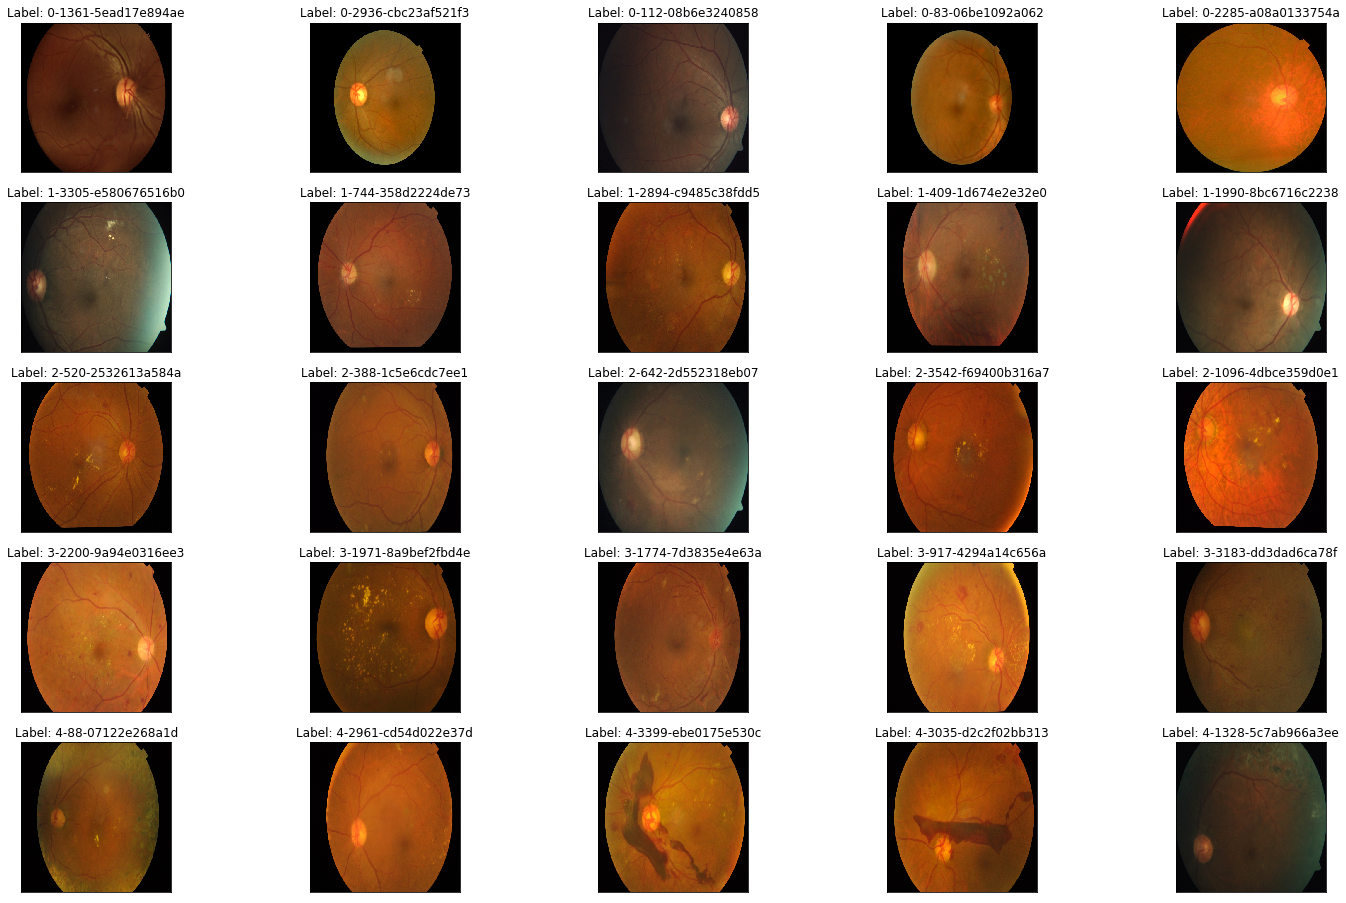

In [8]:
%%time
fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' %(class_id, idx, row['id_code']))

CPU times: user 3.07 s, sys: 108 ms, total: 3.18 s
Wall time: 3 s


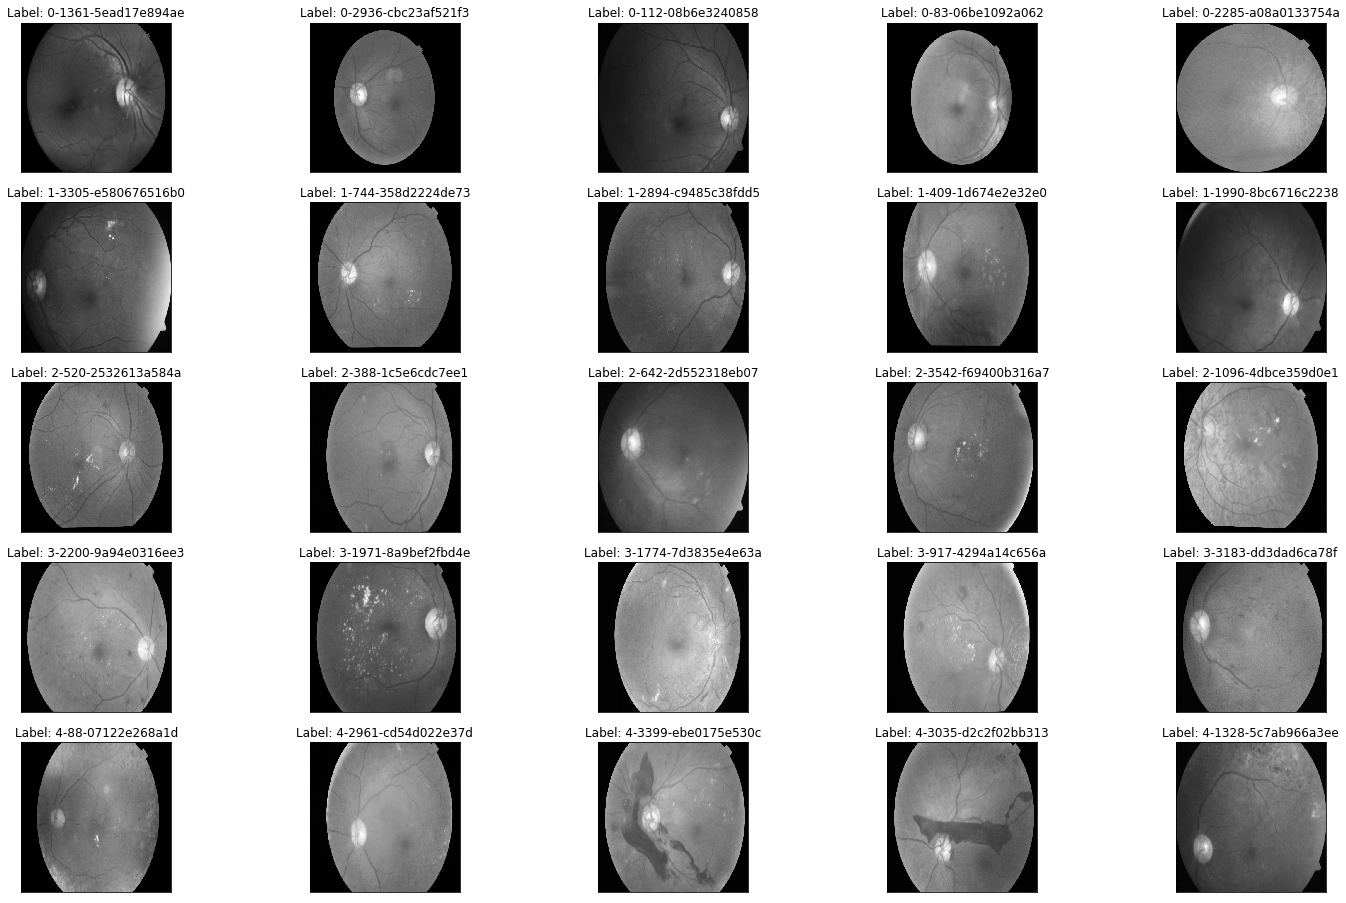

In [11]:
%%time
fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' %(class_id, idx, row['id_code']))

CPU times: user 37.7 s, sys: 152 ms, total: 37.8 s
Wall time: 8.28 s


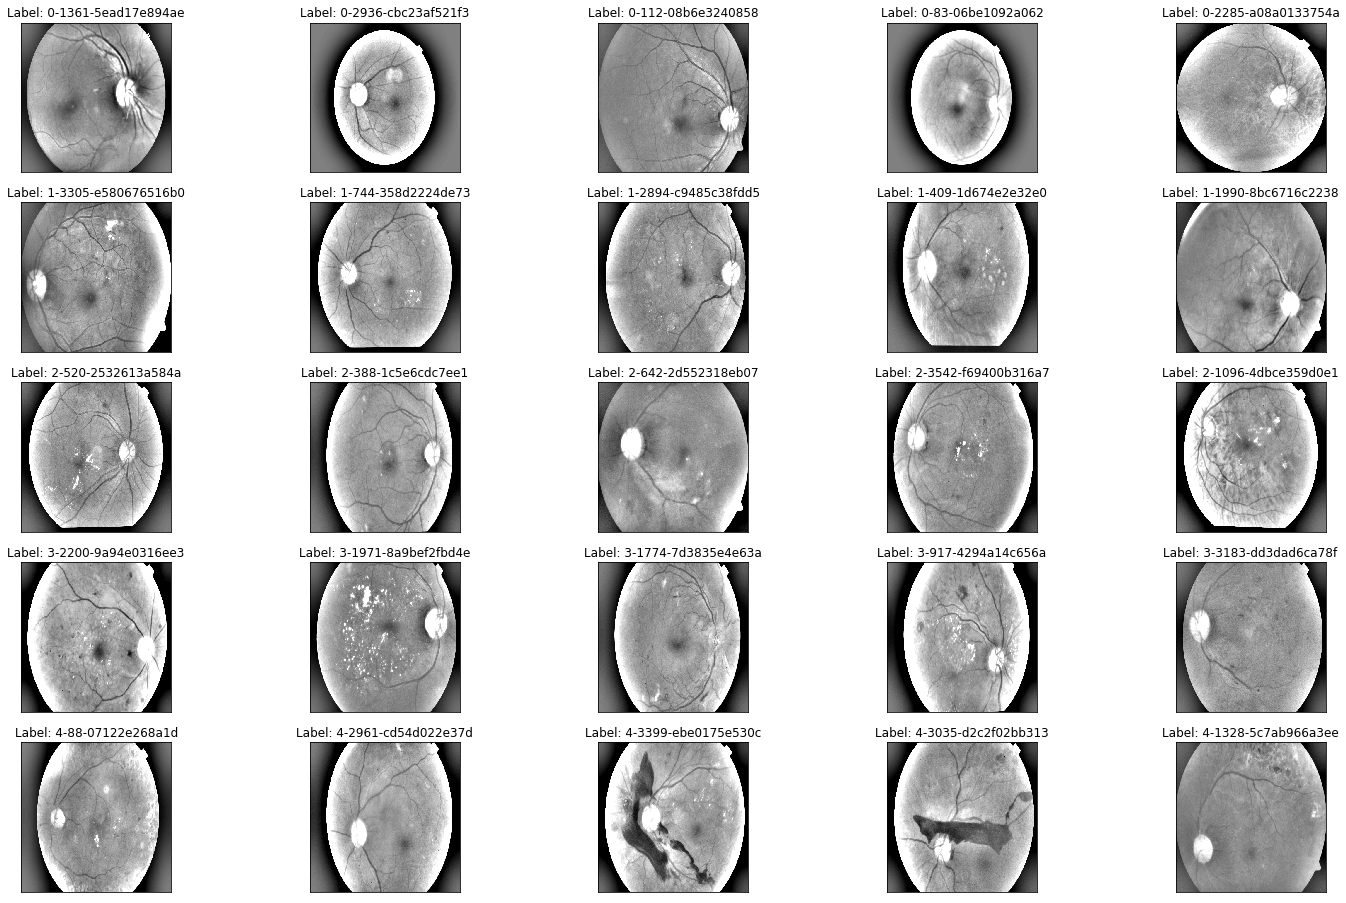

In [12]:
%%time
fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), IMG_SIZE/10), -4, 128)
        
        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' %(class_id, idx, row['id_code']))

# Auto-cropping

In [13]:
def crop_image1(img, tol=7):
    mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [17]:
def circle_crop(img, sigmaX=10):
    img = crop_image_from_gray(img)
    height, width, depth = img.shape
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x, y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), sigmaX), -4, 128)
    return img

CPU times: user 1min 9s, sys: 328 ms, total: 1min 9s
Wall time: 15.9 s


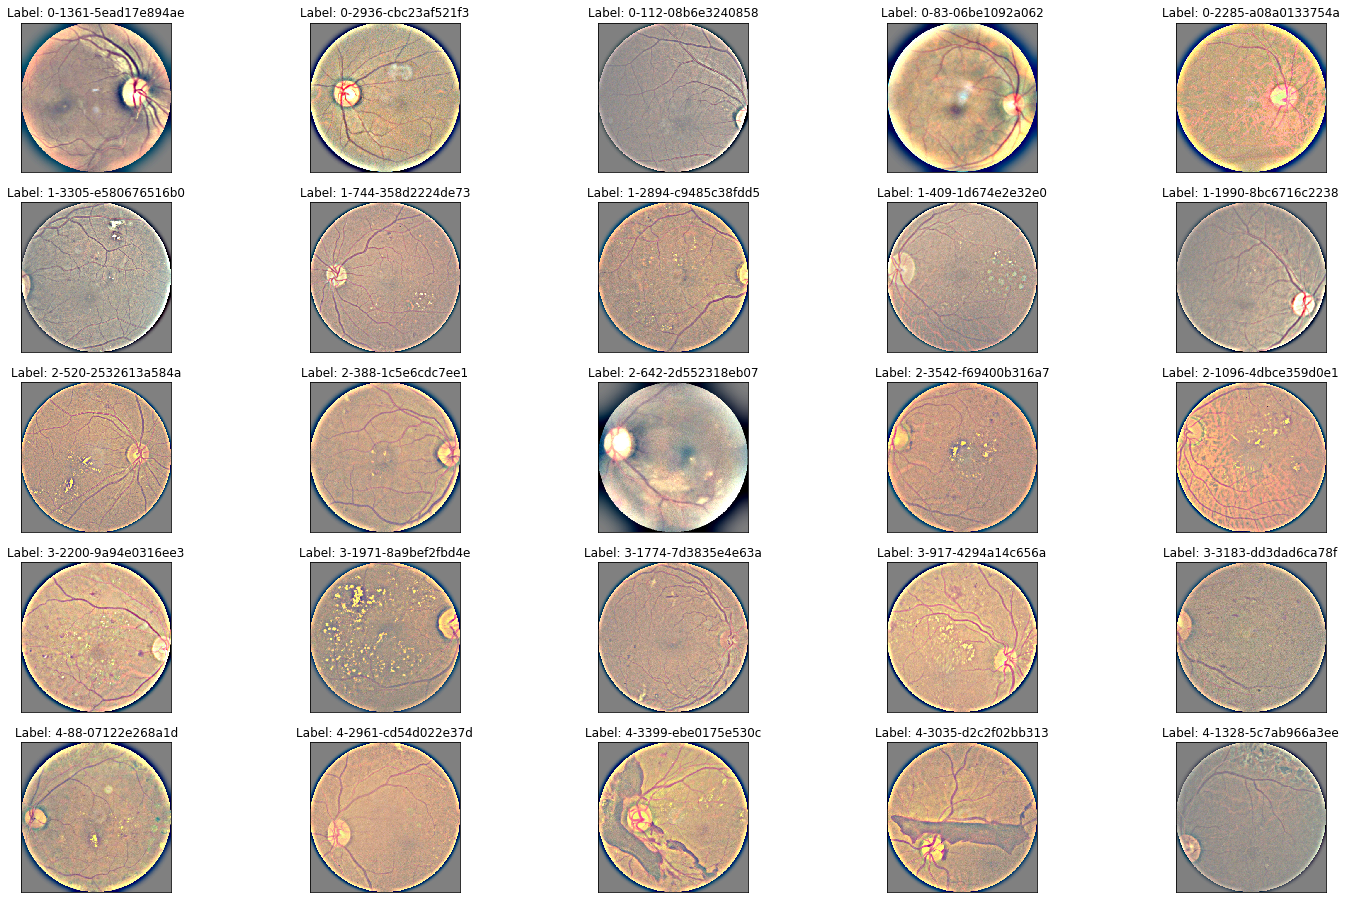

In [21]:
%%time
fig = plt.figure(figsize=(25, 16))

# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = circle_crop(image, sigmaX=30)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' %(class_id, idx, row['id_code']))